In [1]:
cd /Users/Liangqiaohao/Desktop/PV Lab/2020/March/Learning project/P3HT

/Users/Liangqiaohao/Desktop/PV Lab/2020/March/Learning project/P3HT


In [2]:
import numpy as np
import torch
import math
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import GPyOpt
import GPy

import os

import matplotlib as mpl
import matplotlib.tri as tri

import ternary
import pickle
import datetime

from collections import Counter
import matplotlib.ticker as ticker
import random

In [3]:
dataset = pd.read_csv(r'/Users/Liangqiaohao/Desktop/PV Lab/2020/March/Learning project/P3HT/P3HT_dataset.csv')
X = dataset.iloc[:,5:10]
# i put negative sign here because default BO is for minimization
X['Conductivity'] = -dataset.iloc[:,13].values
X_run = X.groupby(['P3HT content (%)', 'D1 content (%)','D2 content (%)','D6 content (%)','D8 content (%)'])['Conductivity'].agg(lambda x: x.unique().mean())
X_run = (X_run.to_frame()).reset_index()

features = ['P3HT content (%)', 'D1 content (%)','D2 content (%)','D6 content (%)','D8 content (%)']
X_feature = X_run[['P3HT content (%)', 'D1 content (%)','D2 content (%)','D6 content (%)','D8 content (%)']].values

X_Conductivity = np.array(X_run['Conductivity'].values)

In [10]:
def normalize_Y(Y):
    mean = np.mean(Y)
    std = np.std(Y)
    Y_ = np.array([(i - mean)/std for i in Y.tolist()])
    return Y_, mean, std

    
def cross_valid(X_feature, y_, kernel):
    assert len(X_feature) == len(y_)
    n = len(X_feature)
    
    seed_list = [74,660,861,1526,2,151,19,7,33,4021]
    total_mae = []    
    n_hold = int(np.round(n * 0.20))
#     n_hold = 1
    
    for s in seed_list:
        print('initializing seed = ' +str(seed_list.index(s)))
        random.seed(s)
        
        indices = list(np.arange(n))
        
        index_ = random.sample(indices, n_hold)
        
        X_test = []
        y_test = []
        
        for i in index_:
            X_test.append(X_feature[i])
            y_test.append(y_[i])
            indices.remove(i)
        
        X_train = X_feature[indices]
        y_train = y_[indices]
        
        y_train_normalized, raw_mean, raw_std = normalize_Y(y_train)
        
        GP_model = GPy.models.GPRegression(X = np.array(X_train), 
                                           Y = np.array([[i] for i in y_train_normalized]), 
                                           kernel= kernel,
                                           noise_var = 0.01
                                          )

        GP_model.optimize_restarts(num_restarts=10,
                                   parallel = True,
                                   robust = True,
                                   optimizer = 'bfgs',
                                   max_iters=100,
                                   verbose = False)
        
        
        
        normalized_pred_mean = GP_model.predict(np.array(X_test))[0][:,0]
        raw_pred_mean = normalized_pred_mean * raw_std + raw_mean
        mae_ = np.sqrt((y_test - raw_pred_mean)**2)
        total_mae.append(np.sum(mae_))
        
    return np.mean(np.array(total_mae))



In [11]:
ARD_ = False

Bias_kernel = GPy.kern.Bias(X_feature.shape[1], variance=1.)

Matern52_kernel = GPy.kern. Matern52(X_feature.shape[1], variance=1., ARD=ARD_) + Bias_kernel
Matern32_kernel = GPy.kern.Matern32(X_feature.shape[1], variance=1., ARD=ARD_) + Bias_kernel
Expo_kernel = GPy.kern.Exponential(X_feature.shape[1], variance=1., ARD=ARD_) + Bias_kernel
RBF_kernel = GPy.kern.RBF(X_feature.shape[1], variance=1., ARD=ARD_) + Bias_kernel


In [12]:
cross_valid(X_feature, X_Conductivity, Matern52_kernel)

initializing seed = 0
initializing seed = 1
initializing seed = 2
initializing seed = 3
initializing seed = 4
initializing seed = 5
initializing seed = 6
initializing seed = 7
initializing seed = 8
initializing seed = 9


2917.7571963010987

In [13]:
cross_valid(X_feature, X_Conductivity, Matern32_kernel)

initializing seed = 0
initializing seed = 1
initializing seed = 2
initializing seed = 3
initializing seed = 4
initializing seed = 5
initializing seed = 6
initializing seed = 7
initializing seed = 8
initializing seed = 9


2879.2256646359915

In [14]:
cross_valid(X_feature, X_Conductivity, Expo_kernel)

initializing seed = 0
initializing seed = 1
initializing seed = 2
initializing seed = 3
initializing seed = 4
initializing seed = 5
initializing seed = 6
initializing seed = 7
initializing seed = 8
initializing seed = 9


2698.661609805315

In [15]:
cross_valid(X_feature, X_Conductivity, RBF_kernel)

initializing seed = 0
initializing seed = 1
initializing seed = 2
initializing seed = 3
initializing seed = 4
initializing seed = 5
initializing seed = 6
initializing seed = 7
initializing seed = 8
initializing seed = 9


2938.9448931892903

In [6]:
X_instability, input_mean, input_std = normalize_Y(X_instability)

In [ ]:
grid_linspace = np.linspace(0, 1, 101)
grid_array = np.array([999, 999, 999])

for i in grid_linspace:
    for j in grid_linspace:
        for k in grid_linspace:
            x = np.array([i, j, k])
            if i + j + k == 1:
                grid_array = np.vstack((grid_array, x))
grid_array = grid_array[1:]

In [21]:
GP_Matern52_kernel = GPy.models.GPRegression(X = np.array(X_feature), 
                                   Y = np.array([[i] for i in X_instability]), 
                                   kernel= Matern52_kernel + Bias_kernel,
                                   noise_var = 0.01
                                  )

GP_Matern52_kernel.optimize_restarts(num_restarts=10,
                           parallel = True,
                           robust = True,
                           optimizer = 'bfgs',
                           max_iters=100,
                           verbose = False)

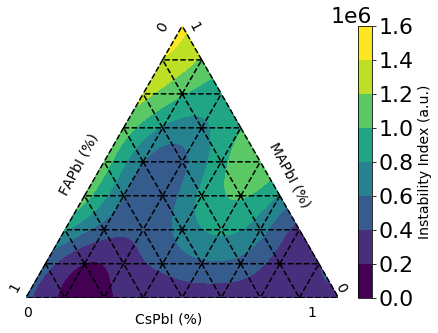

This is the Matern5/2 + Bias


In [14]:
plot_tri(grid_array[:,0],grid_array[:,1],grid_array[:,2], GP_Matern52_kernel.predict(grid_array)[0][:,0] * input_std + input_mean, 'Matern5/2 + Bias', False)

In [15]:
GP_Matern32_kernel = GPy.models.GPRegression(X = np.array(X_feature), 
                                   Y = np.array([[i] for i in X_instability]), 
                                   kernel= Matern32_kernel + Bias_kernel,
                                   noise_var = 0.01
                                  )

GP_Matern32_kernel.optimize_restarts(num_restarts=10,
                           parallel = True,
                           robust = True,
                           optimizer = 'bfgs',
                           max_iters=100,
                           verbose = False)

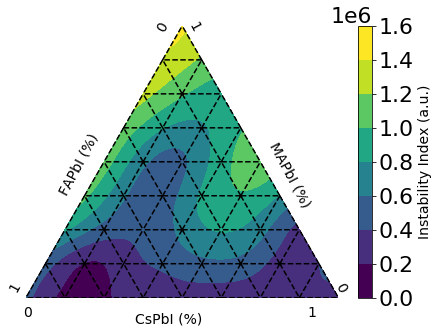

This is the Matern3/2 + Bias


In [16]:
plot_tri(grid_array[:,0],grid_array[:,1],grid_array[:,2], GP_Matern32_kernel.predict(grid_array)[0][:,0] * input_std + input_mean, 'Matern3/2 + Bias', False)

In [17]:
GP_MLP_kernel = GPy.models.GPRegression(X = np.array(X_feature), 
                                   Y = np.array([[i] for i in X_instability]), 
                                   kernel= MLP_kernel + Bias_kernel,
                                   noise_var = 0.01
                                  )

GP_MLP_kernel.optimize_restarts(num_restarts=10,
                           parallel = True,
                           robust = True,
                           optimizer = 'bfgs',
                           max_iters=100,
                           verbose = False)

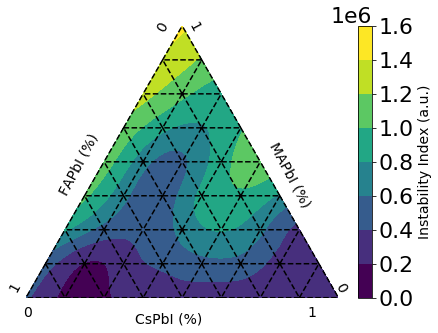

This is the MLP + Bias


In [18]:
plot_tri(grid_array[:,0],grid_array[:,1],grid_array[:,2], GP_MLP_kernel.predict(grid_array)[0][:,0] * input_std + input_mean, 'MLP + Bias', False)

In [19]:
GP_RBF_kernel = GPy.models.GPRegression(X = np.array(X_feature), 
                                   Y = np.array([[i] for i in X_instability]), 
                                   kernel= Expo_kernel + Bias_kernel,
                                   noise_var = 0.01
                                  )

GP_RBF_kernel.optimize_restarts(num_restarts=10,
                           parallel = True,
                           robust = True,
                           optimizer = 'bfgs',
                           max_iters=100,
                           verbose = False)

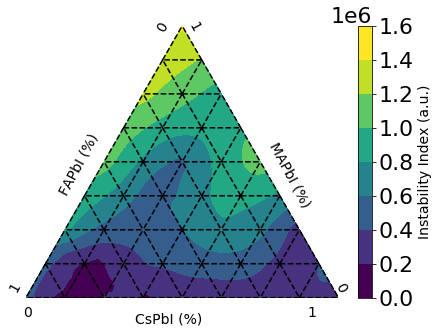

This is the Matern1/2 + Bias


In [21]:
plot_tri(grid_array[:,0],grid_array[:,1],grid_array[:,2], GP_RBF_kernel.predict(grid_array)[0][:,0] * input_std + input_mean, 'Matern1/2 + Bias', False)

In [100]:
# this is essentially just plain Matern5/2 kernel

# BO_teacher = GPyOpt.methods.BayesianOptimization(f=None,  
#                                                  domain = bounds,
#                                                  constraints = constraints_baseline,
#                                                  acquisition_type = 'EI',              
#                                                  normalize_Y = True,
#                                                  X = np.array(X_feature) ,
#                                                  Y = np.array([[i] for i in X_instability]),
#                                                  evaluator_type = 'local_penalization',
#                                                  batch_size = 1,
#                                                  acquisition_jitter = 0.01)

# # we don't care yet, this line here is to just fit the GP
# _ = BO_teacher.suggest_next_locations()